# Распознавание рукописный цифр

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

np.random.seed(17)
tf.random.set_seed(17)

При помощи функционала Tensorflow/Keras мы можем загрузить уже подготовленный датасет прямо в код из репозитория

In [39]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step 
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [40]:
# посмотрим, что у нас имеется:

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

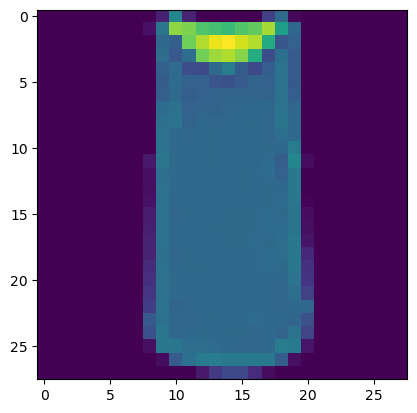

In [41]:
plt.imshow(x_train[2])

In [42]:
x_train[2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 118,  24,   0,
          0,   0,   0,   0,  48,  88,   5,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  12, 100, 212, 205, 185,
        179, 173, 186, 193, 221, 142,  85,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  85,  76, 199, 225,
        248, 255, 238, 226, 157,  68,  80,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  91,  69,  91, 201,
        218, 225, 209, 158,  61,  93,  72,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  79,  89,  61,  59,
         87, 108,  75,  56,  76,  97,  73,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  75,  89,  80,  80,
         67,  63,  73,  83,  80,  96,  72,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [43]:
# в ответах приводятся правильные цифры
y_train[:3]

array([9, 0, 0], dtype=uint8)

Для настройки модели отделим от трейна небольшой кусок на валидационный датасет. На нём мы не будем тренировать нейросеть, но именно на него мы будем ориентироваться для оценки работы модели на новых данных.

In [44]:
val_frac = 0.25

x_val = x_train[round((1-val_frac) * len(x_train)):]
y_val = y_train[round((1-val_frac) * len(y_train)):]

x_train = x_train[:round((1-val_frac) * len(x_train))]
y_train = y_train[:round((1-val_frac) * len(y_train))]

Давайте начнём с какой-нибудь наивной простой последовательной модели и посмотрим, как она сможет натренироваться на таких данных "из коробки".

Т.к. мы имеем дело с задачей мультиклассовой классификации (10 классов цифр от 0 до 9), в качестве последнего слоя задаём слой из 10 нейронов с функцией активации Softmax.

В качестве функции потерь будем использовать Categorical crossentropy loss. В классическом виде она работает с ответами, закодированными посредством OHE. Если же наши ответы закодированы простым числом, стоит использовать её космитическую модификацию: SparseCategoricalCrossentropy.

Первый слой Flatten позволяет "развернуть" наши данные, упакованные в матрицу, в обычный линейный массив, который мы сможем привязать к Dense-слою.

In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(28*28, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_26 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 784)                 │         615,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 500)                 │         392,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,059,050 (4.04 MB)

 Trainable params: 1,059,050 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# натренируем модель на 50 эпохах для начала

history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=1024,
                    epochs=50)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4538 - loss: 73.8749 - val_accuracy: 0.7666 - val_loss: 1.7226
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7716 - loss: 1.5889 - val_accuracy: 0.7647 - val_loss: 1.5555
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7736 - loss: 1.4236 - val_accuracy: 0.8084 - val_loss: 0.8564
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8099 - loss: 0.8396 - val_accuracy: 0.8089 - val_loss: 0.8807
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8184 - loss: 0.7584 - val_accuracy: 0.8297 - val_loss: 0.6770
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8396 - loss: 0.5847 - val_accuracy: 0.8243 - val_loss: 0.7122
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8375 - loss: 0.6006 - val_accuracy: 0.8345 - val_loss: 0.6730
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8532 - loss: 0.5217 - val_accuracy: 0.8454 - 

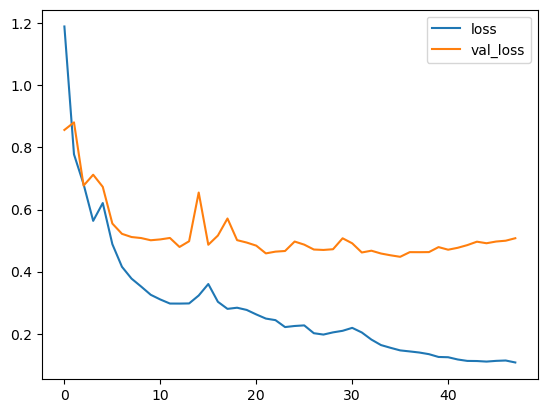

In [47]:
# посмотрим, что у нас с графиками значений функции потерь
# чтобы не отображать на графике первые самые большие значения,
# вырежем из истории самое начало

plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['loss', 'val_loss'])

Loss на трейне продолжает снижаться, но на валидации после ~10-й эпохи он снова пошёл вверх. Это классическая ситуация переобучения: наша модель так хорошо "запомнила" обучающий датасет, что на новых данных уже даёт худшие результаты.

Давайте попробуем добавить слои Batch Normalozation и посмотрим, повлияют ли они как-то на процесс обучения.

In [48]:
# Добавляем батчнорм

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(28*28, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_27 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 784)                 │         615,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 500)                 │         392,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_78               │ (None, 500)                 │           2,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_79               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,067,722 (4.07 MB)

 Trainable params: 1,063,386 (4.06 MB)

 Non-trainable params: 4,336 (16.94 KB)

Обратите внимание, что в слоях batch_normalization тоже присутствуют обучаемые параметры. В итоге количество обучаемых параметровв нашей модели слегка увеличилось. Но зато батчнорм можно использовать и без настройки гиперпараметров.

In [49]:
# обучаем новую модель

history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=1024,
                    epochs=50)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7326 - loss: 0.8055 - val_accuracy: 0.7125 - val_loss: 0.8965
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8811 - loss: 0.3279 - val_accuracy: 0.8214 - val_loss: 0.4941
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9035 - loss: 0.2724 - val_accuracy: 0.8589 - val_loss: 0.3802
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9187 - loss: 0.2317 - val_accuracy: 0.8741 - val_loss: 0.3525
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9313 - loss: 0.1973 - val_accuracy: 0.8755 - val_loss: 0.3400
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9385 - loss: 0.1733 - val_accuracy: 0.8763 - val_loss: 0.3453
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9483 - loss: 0.1508 - val_accuracy: 0.8791 - val_loss: 0.3477
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9533 - loss: 0.1343 - val_accuracy: 0.8809 - v

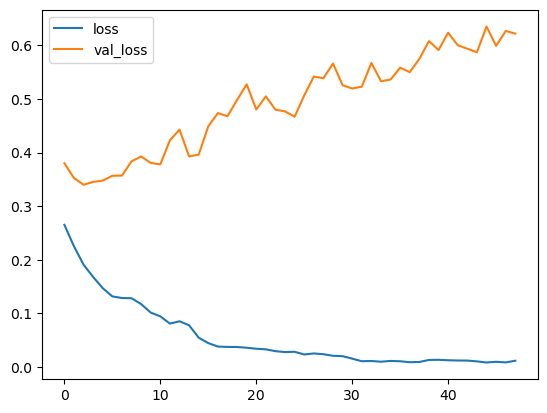

In [50]:
# посмотрим, что теперь на графиках

plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['loss', 'val_loss'])

Как можно видеть из графиков, батчнорм ускорил обучение: модель доходит до своего лучшего состояния уже примерно за ~5 эпох. Более того, дальше на трейне модель обучается настолько хорошо, что запоминает 100% данных: Loss уходит в ноль, а метрика возрастает до единицы. 

Это плохая ситуация, ведь из-за такого переобучения наша точность на валидации снижается. Модель получилась достаточно сложная, раз она может всё запомнить. Есть смысл попробовать её немного упростить (например, выкинув какие-то слои). Заодно давайте и добавим коллбэк EarlyStopping, чтобы не ждать каждый раз все 50 эпох. 

In [60]:
# в новой модели выкинем самый большой слой (и соответствующий ему батчнорм)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(28*28, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # тут был слой на 500 нейронов
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [61]:
# в параметре monitor у EarlyStopping укажем величину, которую будем пониторить
# а в параметре patience - количество эпох, в ходе которых эта величина не должна улучшаться

stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=4,
                                            verbose=1)

history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=1024,
                    epochs=50,
                    callbacks=[stopping]) # добавляем коллбэк в цикл обучения

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7209 - loss: 0.8403 - val_accuracy: 0.7586 - val_loss: 0.8278
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8744 - loss: 0.3507 - val_accuracy: 0.8399 - val_loss: 0.4394
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8967 - loss: 0.2948 - val_accuracy: 0.8656 - val_loss: 0.3694
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9109 - loss: 0.2552 - val_accuracy: 0.8721 - val_loss: 0.3486
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9223 - loss: 0.2238 - val_accuracy: 0.8759 - val_loss: 0.3437
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9337 - loss: 0.1940 - val_accuracy: 0.8766 - val_loss: 0.3409
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9449 - loss: 0.1671 - val_accuracy: 0.8784 - val_loss: 0.3377
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9503 - loss: 0.1483 - val_accuracy: 0.8782 - v

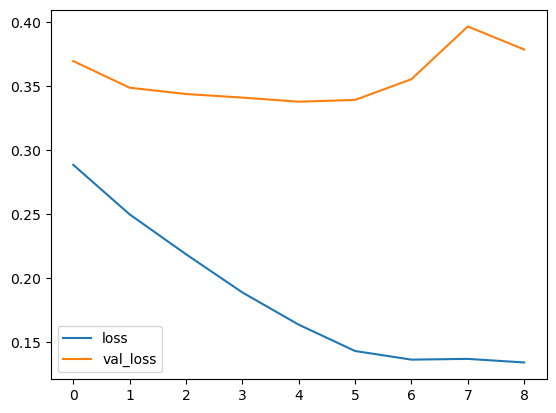

In [62]:
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['loss', 'val_loss'])

Теперь не обязательно ждать: обучение само останавливается, когда начинается оверфиттинг.

Давайте попробуем добавить дропаут и посмотрим, как это повлияет на наш процесс обучения.

In [65]:
# добавялем дропаут в после промежуточных слоёв

model = tf.keras.models.Sequential([
   tf.keras.layers.Flatten(input_shape=(28, 28)),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dense(300, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dropout(0.4),
   tf.keras.layers.Dense(300, activation='relu'),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dropout(0.4),
   tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [66]:
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=1024,
                    epochs=50,
                    callbacks=[stopping]) # а коллбэк у нас уже создан

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6064 - loss: 1.2716 - val_accuracy: 0.7583 - val_loss: 0.8856
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8132 - loss: 0.5266 - val_accuracy: 0.8310 - val_loss: 0.5091
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8364 - loss: 0.4521 - val_accuracy: 0.8619 - val_loss: 0.3945
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8522 - loss: 0.4158 - val_accuracy: 0.8713 - val_loss: 0.3656
Epoch 4: early stopping


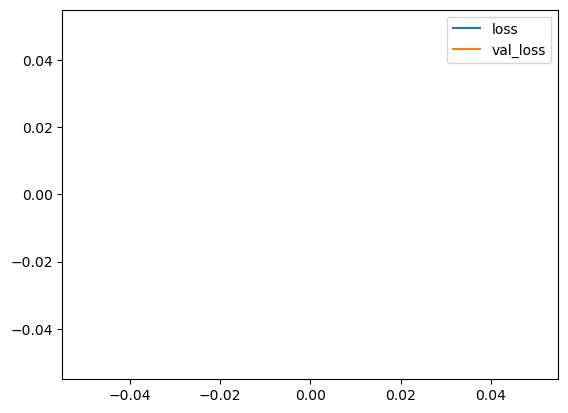

In [56]:
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['loss', 'val_loss'])

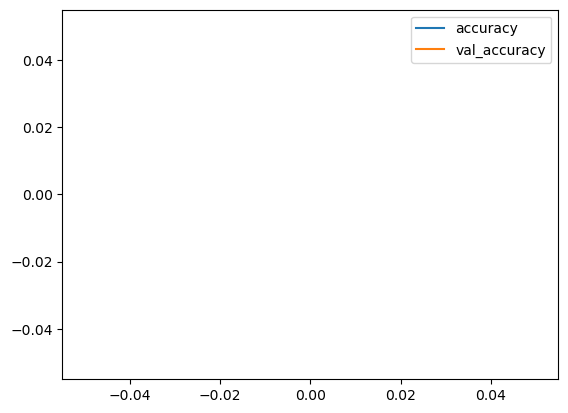

In [57]:
plt.plot(history.history['accuracy'][2:])
plt.plot(history.history['val_accuracy'][2:])
plt.legend(['accuracy', 'val_accuracy'])

В начале обучения точность на вализации даже лучше, чем на трейне. Это типичная ситуация при использовании дропаута: ведь на трейне у в модели выключаются некоторые нейроны, а на валидации модель работает "на полную". 

Что ж, значение дропаута 0.5 мы поставили "пальцем в небо", а это всё-таки гиперпараметр, который может повлиять на работу модели. Давайте попробуем натренировать много разных моделей с разными значениями дропаута и посмотрим, какая из них покажет себя лучше всего.

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6591 - loss: 1.0680 - val_accuracy: 0.7685 - val_loss: 0.7176
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8448 - loss: 0.4359 - val_accuracy: 0.8437 - val_loss: 0.4310
Epoch 2: early stopping
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6372 - loss: 1.1442 - val_accuracy: 0.7493 - val_loss: 0.8160
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8311 - loss: 0.4741 - val_accuracy: 0.8290 - val_loss: 0.4843
Epoch 2: early stopping
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6078 - loss: 1.3080 - val_accuracy: 0.7411 - val_loss: 0.9479
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8159 - loss: 0.5292 - val_accuracy: 0.8263 - val_loss: 0.5088
Epoch 2: early stopping
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5700 - loss: 1.4617 - val_accuracy: 0.7315 - val_loss: 1.1514
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1

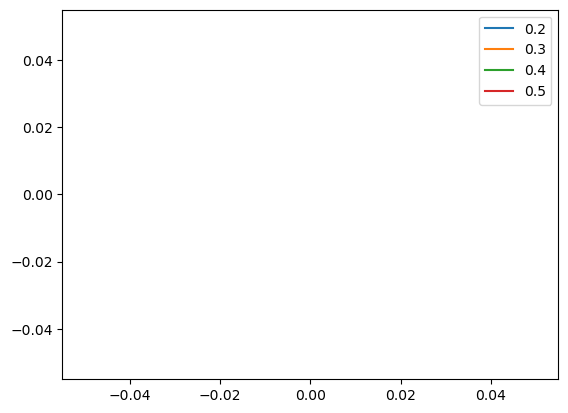

In [58]:
# зададим значения дропаута, которые будем испытывать
dropout_range = [0.2, 0.3, 0.4, 0.5]

# для каждого значения натренируем свою модель
for drp in dropout_range:
    model = tf.keras.models.Sequential([
       tf.keras.layers.Flatten(input_shape=(28, 28)),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dense(300, activation='relu'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(drp),
       tf.keras.layers.Dense(300, activation='relu'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(drp),
       tf.keras.layers.Dense(10, activation='softmax')
])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        batch_size=1024,
                        epochs=50,
                        callbacks=[stopping]) # коллбэк не позволит переобучиться, не нужно заморачиваться над лоссом
    
    # после завершения обучения построим графики
    # значений нашей метрики на валидации
    plt.plot(history.history['val_accuracy'][2:])

plt.legend(dropout_range)
plt.show()


Модели с большим дропаутом закономерно учатся дольше. Тем не менее, и качество у них похуже: лучше всего показывает себя модель с дропаутом ~0.1-0.2. Его и будем использовать.

Итак, мы выбрали лучшее значение дропаута.

Давайте теперь построим с ним финальную модель, обучим её чуть подольше, а потом сами выберем эпоху, на которой модель показала себя лучше всего. Для этого воспользуемся коллбэком ModelCheckpoint, который позволит сохранить веса модели, а затем просто загрузим веса из нужной эпохи.

In [34]:
# финальная модель

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(28*28, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# в коллбэке укажем шаблон для названия файлов с весами
# в нашем случае там будет указываться номер эпохи и значение функции потерь
check = tf.keras.callbacks.ModelCheckpoint(filepath='test_workshop.weights.h5',
                                           save_weights_only=True)

history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=1024,
                    epochs=30, # 30 эпох уж точно будет достаточно
                    callbacks=[check])

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7551 - loss: 0.8222 - val_accuracy: 0.9229 - val_loss: 0.2543
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9520 - loss: 0.1662 - val_accuracy: 0.9485 - val_loss: 0.1874
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9699 - loss: 0.1078 - val_accuracy: 0.9577 - val_loss: 0.1547
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9810 - loss: 0.0732 - val_accuracy: 0.9639 - val_loss: 0.1348
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9873 - loss: 0.0491 - val_accuracy: 0.9672 - val_loss: 0.1236
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9930 - loss: 0.0330 - val_accuracy: 0.9669 - val_loss: 0.1213
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9958 - loss: 0.0221 - val_accuracy: 0.9698 - val_loss: 0.1160
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9972 - loss: 0.0175 - val_accuracy: 0.9688 - v

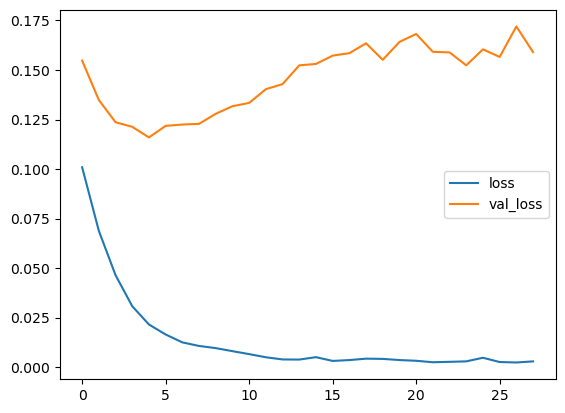

In [35]:
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.legend(['loss', 'val_loss'])

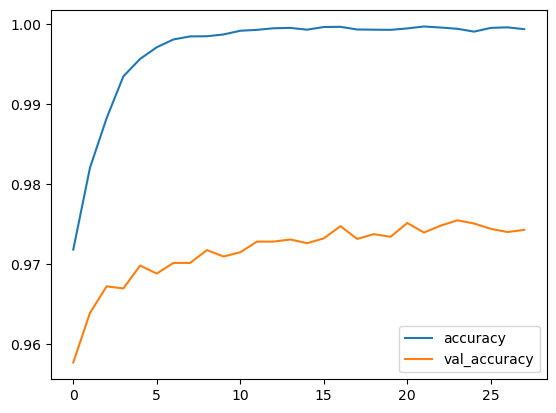

In [36]:
plt.plot(history.history['accuracy'][2:])
plt.plot(history.history['val_accuracy'][2:])
plt.legend(['accuracy', 'val_accuracy'])

Лучшее значение получилось в 5-й точке на графике. Это 7-я эпоха (мы ведь отрезали первые 2). 

Давайте считать модель с этими весами наилучшей, загрузим их:

In [37]:
model.load_weights('test_workshop.weights.h5')

Наконец мы можем проверить нашу модель и на тестовых данных, которые мы держали в стороне весь процесс обучения. Т.к. мы конструировали модель, ориентируясь на валидацию, может случиться и так, что на тесте модель будет вести себя хуже. Что ж, давайте проверим.

In [38]:
print('Проверяем на тестовых данных:')
model.evaluate(x_test, y_test)

print('А на валидации было:')
model.evaluate(x_val, y_val)

Проверяем на тестовых данных:
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9741 - loss: 0.1292
А на валидации было:
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9711 - loss: 0.1887


[0.15904833376407623, 0.9742666482925415]

На тесте показатели оказались даже чуть лучше, чем на валидации. Это однозначно говорит нам о том, что модель будет верным образом вести себя и на новых данных.

Точность в 97,4% - достаточно хороший показатель для такой простой модели как полносвязная нейросеть (с некоторыми плюшками). На данном датасете можно и немного увеличить точность работы, но для этого уже обычно применяются более сложные архитектуры, с которыми мы познакомимся позже.